# loading environment variables

In [39]:
from dotenv import load_dotenv
load_dotenv()

import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
  os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key for langsmith: ")

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

# initializations

chat model

In [3]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

embedding model

In [4]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vector store

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# load documents 

In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

USER_AGENT environment variable not set, consider setting it to identify your requests.


# load prompt

In [8]:
from langchain import hub

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


# build graph

In [18]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    
    
# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

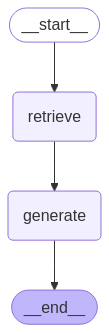

In [22]:
graph

# Usage

In [24]:
response = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {response["context"]}\n\n')
print(f'Answer: {response["answer"]}')

Context: [Document(id='2321c6fc-4924-461d-b48a-4f1883b52472', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='bc17adba-10f8-40d8-b7f7-819c5bde9cec', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent sys

stream steps

In [25]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='2321c6fc-4924-461d-b48a-4f1883b52472', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='bc17adba-10f8-40d8-b7f7-819c5bde9cec', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered auto

stream tokens

In [26]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| manageable| steps| or| sub|go|als|.| This| can| be| accomplished| by| using| various| methods| such| as| simple| prompting|,| task|-specific| instructions|,| or| human| inputs|.| The| goal| is| to| enhance| understanding| and| improve| performance| by| transforming| large| tasks| into| simpler| ones| for| easier| processing| and| execution|.||

# query analysis

In [29]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

In [31]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [34]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

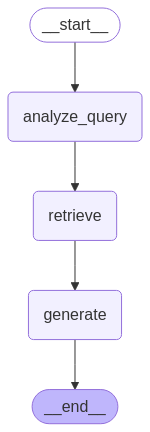

In [35]:
graph

In [36]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='a4318d25-139b-4b5c-b9ab-4057c4ada8ff', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide more information about ho

In [37]:
for step in graph.stream(
    {"question": "What does the middle of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'middle'}}}

----------------

{'retrieve': {'context': [Document(id='e665726f-dd04-481e-8224-36019342db9e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'middle'}, page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe system comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.\nInstruction:'), Document(id='8669f667-7320-46bd-893e-0833290e8e9b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'middle'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-3.5 powered Agents for delegation of 

In [38]:
for step in graph.stream(
    {"question": "What does the starting of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='2321c6fc-4924-461d-b48a-4f1883b52472', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='bc17adba-10f8-40d8-b7f7-819c5bde9cec', 